# Twitter Pulse Checker

![preview](https://cdn.pixabay.com/photo/2013/06/07/09/53/twitter-117595_960_720.png)

In [1]:
# import lots of stuff
import sys
import os
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [2]:
# install Flair
!pip install --upgrade git+https://github.com/flairNLP/flair.git

clear_output()

In [3]:
# import Flair stuff
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')

clear_output()

In [4]:
#import Flair Classifier
from flair.models import TextClassifier

classifier = TextClassifier.load('en-sentiment')

clear_output()

### Authenticate with Twitter API

In [5]:
#@title Enter Twitter Credentials
TWITTER_KEY = '87gqIlmDpPVS3OJMoEYsMiNYU' #@param {type:"string"}
TWITTER_SECRET_KEY = '4wjZYPW9P7WM74Aq1gpd6v5ylKvdqWpSh2mCDsInH5OkfxK43e' #@param {type:"string"}

In [6]:
# Authenticate
auth = tweepy.AppAuthHandler(TWITTER_KEY, TWITTER_SECRET_KEY)

api = tweepy.API(auth, wait_on_rate_limit=True,
				   wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)


###Lets start scraping!

The Twitter scrape code here was taken from: https://bhaskarvk.github.io/2015/01/how-to-use-twitters-search-rest-api-most-effectively.

My thanks to the author.

We need to provide a Search term and a Max Tweet count. Twitter lets you to request 45,000 tweets every 15 minutes  so setting something below that works.

In [10]:
#@title Twitter Search API Inputs
#@markdown ### Enter Search Query:
searchQuery = 'Petrol' #@param {type:"string"}
#@markdown ### Enter Max Tweets To Scrape:
#@markdown #### The Twitter API Rate Limit (currently) is 45,000 tweets every 15 minutes.
maxTweets = 2000 #@param {type:"slider", min:0, max:45000, step:100}
Filter_Retweets = True #@param {type:"boolean"}

tweetsPerQry = 100  # this is the max the API permits
tweet_lst = []

if Filter_Retweets:
  searchQuery = searchQuery + ' -filter:retweets'  # to exclude retweets

# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -10000000000

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
while tweetCount < maxTweets:
    try:
        if (max_id <= 0):
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang="en")
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", since_id=sinceId)
        else:
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1))
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1),
                                        since_id=sinceId)
        if not new_tweets:
            print("No more tweets found")
            break
        for tweet in new_tweets:
          if hasattr(tweet, 'reply_count'):
            reply_count = tweet.reply_count
          else:
            reply_count = 0
          if hasattr(tweet, 'retweeted'):
            retweeted = tweet.retweeted
          else:
            retweeted = "NA"
            
          # fixup search query to get topic
          topic = searchQuery[:searchQuery.find('-')].capitalize().strip()
          
          # fixup date
          tweetDate = tweet.created_at.date()
          
          tweet_lst.append([tweetDate, topic, 
                      tweet.id, tweet.user.screen_name, tweet.user.name, tweet.text, tweet.favorite_count, 
                      reply_count, tweet.retweet_count, retweeted])

        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        # Just exit if any error
        print("some error : " + str(e))
        break

clear_output()
print("Downloaded {0} tweets".format(tweetCount))

Downloaded 2000 tweets


##Data Sciencing

Let's load the tweet data into a Pandas Dataframe so we can do Data Science to it. 

The data is also saved down in a tweets.csv file in case you want to download it.

In [11]:
pd.set_option('display.max_colwidth', -1)

# load it into a pandas dataframe
tweet_df = pd.DataFrame(tweet_lst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'like_count', 'reply_count', 'retweet_count', 'retweeted'])
tweet_df.to_csv('tweets.csv')
tweet_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2021-05-04,Petrol,1389618125600174082,kumaaravelu,kumaar,"@mkstalin How about workers in the fuel stations, are they not front line workers. People working in Petrol Bunks a… https://t.co/DMOowTArxK",0,0,0,False
1,2021-05-04,Petrol,1389618115835621378,MoPNG_eSeva,MoPNG e-Seva,"@Nikhils66792000 @BPCLimited Kindly DM us the name, location of the concerned retail outlet i.e. the petrol pump",0,0,0,False
2,2021-05-04,Petrol,1389618106994204672,Olivercocker,KB,"All I want for Christmas is a matt black, teardrop petrol tank FOR MY FUUCKIN CHOP!",0,0,0,False
3,2021-05-04,Petrol,1389618014325252096,kimjongun667,Kim Jong Un,@Froste @stoneymaIoney Y’all call liquid petrol gas,1,0,0,False
4,2021-05-04,Petrol,1389617978304385030,ozgoldtimes,Ozgoldtimes,"In Australia we abbreviate everything usually with ""o"" or ""ie/y"" like bottle shop (liquor store) to ""bottleo"" or se… https://t.co/XyjpIPyUR6",0,0,0,False


Unfortunately Twitter does not let you filter by date when you request tweets. However, we can do this at this stage. I have set it up to pull yesterday + todays Tweets by default.

In [12]:
#@title Filter By Date Range
today = datetime.now().date()
yesterday = today - timedelta(1)

start_dt = '2021-04-22' #@param {type:"date"}
end_dt = '2021-05-04' #@param {type:"date"}

if start_dt == '':
  start_dt = yesterday
else:
  start_dt = datetime.strptime(start_dt, '%Y-%m-%d').date()

if end_dt == '':
  end_dt = today
else:
  end_dt = datetime.strptime(end_dt, '%Y-%m-%d').date()


tweet_df = tweet_df[(tweet_df['tweet_dt'] >= start_dt) 
                    & (tweet_df['tweet_dt'] <= end_dt)]
tweet_df.shape

(2000, 10)

## NER and Sentiment Analysis

Now let's do some NER / Sentiment Analysis. We will use the Flair library: https://github.com/zalandoresearch/flair

###NER

Previosuly, we extracted, and then appended the Tags as separate rows in our dataframe. This helps us later on to Group by Tags.

We also create a new 'Hashtag' Tag as Flair does not recognize it and it's a big one in this context.

### Sentiment Analysis

We use the Flair Classifier to get Polarity and Result and add those fields to our dataframe.

**Warning:** This can be slow if you have lots of tweets.

In [13]:
# predict NER
nerlst = []

for index, row in tqdm(tweet_df.iterrows(), total=tweet_df.shape[0]):
  cleanedTweet = row['tweet'].replace("#", "")
  sentence = Sentence(cleanedTweet, use_tokenizer=True)
  
  # predict NER tags
  tagger.predict(sentence)

  # get ner
  ners = sentence.to_dict(tag_type='ner')['entities']
  
  # predict sentiment
  classifier.predict(sentence)
  
  label = sentence.labels[0]
  response = {'result': label.value, 'polarity':label.score}
  
  # get hashtags
  hashtags = re.findall(r'#\w+', row['tweet'])
  if len(hashtags) >= 1:
    for hashtag in hashtags:
      ners.append({ 'type': 'Hashtag', 'text': hashtag })
  
  for ner in ners:
    adj_polarity = response['polarity']
    if response['result'] == 'NEGATIVE':
      adj_polarity = response['polarity'] * -1
    try:
      ner['type']
    except:
      ner['type'] = ''      
    nerlst.append([ row['tweet_dt'], row['topic'], row['id'], row['username'], 
                   row['name'], row['tweet'], ner['type'], ner['text'], response['result'], 
                   response['polarity'], adj_polarity, row['like_count'], row['reply_count'], 
                  row['retweet_count'] ])

clear_output()

In [14]:
df_ner = pd.DataFrame(nerlst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity', 
                                       'adj_polarity','like_count', 'reply_count', 'retweet_count'])
df_ner

,tweet_dt,topic,id,username,name,tweet,tag_type,tag,sentiment,polarity,adj_polarity,like_count,reply_count,retweet_count
0,2021-05-04,Petrol,1389618125600174082,kumaaravelu,kumaar,"@mkstalin How about workers in the fuel stations, are they not front line workers. People working in Petrol Bunks a… https://t.co/DMOowTArxK",,Petrol Bunks,NEGATIVE,0.977087,-0.977087,0,0,0
1,2021-05-04,Petrol,1389617978304385030,ozgoldtimes,Ozgoldtimes,"In Australia we abbreviate everything usually with ""o"" or ""ie/y"" like bottle shop (liquor store) to ""bottleo"" or se… https://t.co/XyjpIPyUR6",,Australia,NEGATIVE,0.913649,-0.913649,0,0,0
2,2021-05-04,Petrol,1389617404515393538,iamkingmonye,King Monye 👑,"FCMB and Oando is doing #FreeFuelWithFcmbVerve prom. You too can get extra liters of fuel when you purchase N3,000… https://t.co/YK1ArsCt2R",,FCMB,POSITIVE,0.574203,0.574203,33,0,33
3,2021-05-04,Petrol,1389617404515393538,iamkingmonye,King Monye 👑,"FCMB and Oando is doing #FreeFuelWithFcmbVerve prom. You too can get extra liters of fuel when you purchase N3,000… https://t.co/YK1ArsCt2R",,Oando,POSITIVE,0.574203,0.574203,33,0,33
4,2021-05-04,Petrol,1389617404515393538,iamkingmonye,King Monye 👑,"FCMB and Oando is doing #FreeFuelWithFcmbVerve prom. You too can get extra liters of fuel when you purchase N3,000… https://t.co/YK1ArsCt2R",Hashtag,#FreeFuelWithFcmbVerve,POSITIVE,0.574203,0.574203,33,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,2021-05-04,Petrol,1389392521399177218,ZeeNewsEnglish,Zee News English,"#Petrol &amp; #Diesel Price, May 04, 2021: #Fuelprices hiked after an 18-day pause; check prices in metro cities\n\nhttps://t.co/AJIPY4RHJM",Hashtag,#Diesel,NEGATIVE,0.997016,-0.997016,37,0,4
1994,2021-05-04,Petrol,1389392521399177218,ZeeNewsEnglish,Zee News English,"#Petrol &amp; #Diesel Price, May 04, 2021: #Fuelprices hiked after an 18-day pause; check prices in metro cities\n\nhttps://t.co/AJIPY4RHJM",Hashtag,#Fuelprices,NEGATIVE,0.997016,-0.997016,37,0,4
1995,2021-05-04,Petrol,1389392281963171841,sydney_ev,🔋SydEV 🌿💧 #FSDBetaAU #FSDBetaOZ,"@GB38251626 @DanielBleakley @TheDriven_io with no policy, we won't get the new #EVS, we will get the old… https://t.co/fSnuYTxHh9",Hashtag,#EVS,NEGATIVE,0.999778,-0.999778,1,0,0
1996,2021-05-04,Petrol,1389391222716829696,DebtonoyaDas,Debtonoya Das 🇮🇳🕉,Dear @Olacabs @Olacare_AU I book a ride the driver calls and asks me the amount being shown and whether I am paying… https://t.co/KiKQVxosef,,Olacare,NEGATIVE,0.734794,-0.734794,1,0,1


Let's filter out obvious tags like #Seattle that would show up for this search. You can comment this portion out or use different Tags for your list.

In [15]:
# filter out obvious tags
# banned_words = ['Seattle', 'WA', '#Seattle', '#seattle', 'Washington', 'SEATTLE', 'WASHINGTON',
#                 'seattle', 'Seattle WA', 'seattle wa','Seattle, WA', 'Seattle WA USA', 
#                 'Seattle, Washington', 'Seattle Washington', 'Wa', 'wa', '#Wa',
#                '#wa', '#washington', '#Washington', '#WA', '#PNW', '#pnw', '#northwest']

banned_words = ['Petrol']

df_ner = df_ner[~df_ner['tag'].isin(banned_words)]

Calculate Frequency, Likes, Replies, Retweets and Average Polarity per Tag.

In [16]:
ner_groups = df_ner.groupby(['tag', 'tag_type']).agg({'tag': "count", 'adj_polarity': "mean",
                                                     'like_count': 'sum', 'reply_count': 'sum',
                                                     'retweet_count': 'sum'})
ner_groups = ner_groups.rename(columns={
    "tag": "Frequency",
    "adj_polarity": "Avg_Polarity",
    "like_count": "Total_Likes",
    "reply_count": "Total_Replies",
    "retweet_count": "Total_Retweets"
})
ner_groups = ner_groups.sort_values(['Frequency'], ascending=False)
ner_groups = ner_groups.reset_index()
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets
0,India,,67,-0.744925,203,0,271
1,Modi,,54,-0.785718,120,0,264
2,US,,54,-0.321054,4,0,0
3,#PetrolDieselPriceHike,Hashtag,51,-0.285090,239,0,101
4,Sanatani,,42,-0.867467,90,0,254


Create an overall Sentiment column based on the Average Polarity of the Tag.

In [17]:
ner_groups['Sentiment'] = np.where(ner_groups['Avg_Polarity']>=0, 'POSITIVE', 'NEGATIVE')
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets,Sentiment
0,India,,67,-0.744925,203,0,271,NEGATIVE
1,Modi,,54,-0.785718,120,0,264,NEGATIVE
2,US,,54,-0.321054,4,0,0,NEGATIVE
3,#PetrolDieselPriceHike,Hashtag,51,-0.285090,239,0,101,NEGATIVE
4,Sanatani,,42,-0.867467,90,0,254,NEGATIVE


## Visualize!

We can get some bar plots for the Tags based on the following metrics:



*   Most Popular Tweets
*   Most Liked Tweets
*   Most Replied Tweets
*   Most Retweeted Tweets

By default, we do the analysis on all the Tags but we can also filter by Tag by checking the Filter_TAG box. 
This way we can further drill down into the metrics for Hashtags, Persons, Locations & Organizations.

We cut the plots by Sentiment i.e. the color of the bars tells us if the overall Sentiment was Positive or Negative.


Text(0.5, 0, '')

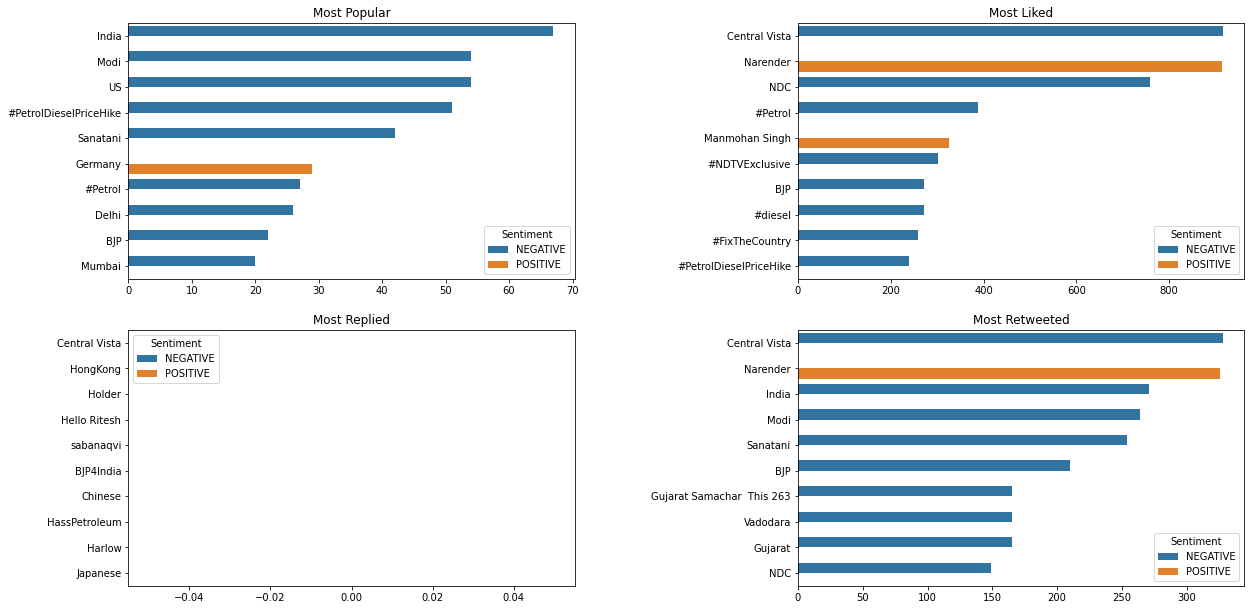

In [18]:
#@title Visualize Top TAGs
Filter_TAG = False #@param {type:"boolean"}
TAG = 'Hashtag' #@param ["Hashtag", "Person", "Location", "Organization"]
#@markdown ###Pick how many tags to display per chart:
Top_N = 10 #@param {type:"integer"}

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

# plot the figures
fig = plt.figure(figsize=(20, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.5)

ax1 = fig.add_subplot(321)
sns.barplot(x="Frequency", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax2 = fig.add_subplot(322)
filtered_group = filtered_group.sort_values(['Total_Likes'], ascending=False)
sns.barplot(x="Total_Likes", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax3 = fig.add_subplot(323)
filtered_group = filtered_group.sort_values(['Total_Replies'], ascending=False)
sns.barplot(x="Total_Replies", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax4 = fig.add_subplot(324)
filtered_group = filtered_group.sort_values(['Total_Retweets'], ascending=False)
sns.barplot(x="Total_Retweets", y="tag", data=filtered_group[:Top_N], hue="Sentiment")

ax1.title.set_text('Most Popular')
ax2.title.set_text('Most Liked')
ax3.title.set_text('Most Replied')
ax4.title.set_text('Most Retweeted')

ax1.set_ylabel('')    
ax1.set_xlabel('')
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax4.set_ylabel('')    
ax4.set_xlabel('')

###Get the Average Polarity Distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


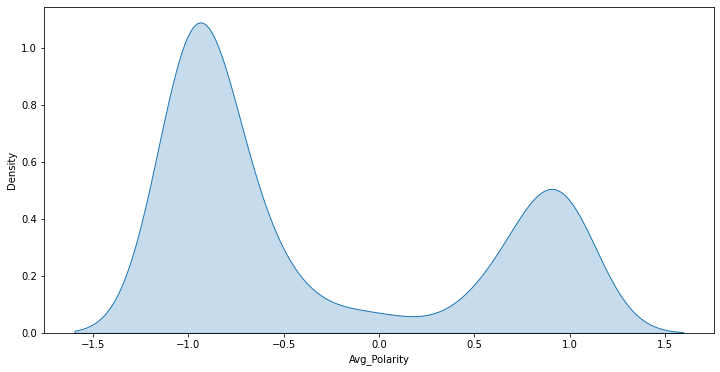

In [19]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(filtered_group['Avg_Polarity'], hist=False, kde_kws={"shade": True})

## Word Cloud

Let's build a Word Cloud based on these metrics. 

Since I am interested in Seattle, I am going to use overlay the Seattle city skyline view over my Word Cloud. 
You can change this by selecting a different Mask option from the drop down.

Images for Masks can be found at:

http://clipart-library.com/clipart/2099977.htm

https://needpix.com

In [21]:
# download mask images
!wget http://clipart-library.com/img/2099977.jpg -O seattle.jpg
!wget https://storage.needpix.com/rsynced_images/trotting-horse-silhouette.jpg -O horse.jpg
!wget https://storage.needpix.com/rsynced_images/black-balloon.jpg -O balloon.jpg
  
clear_output()

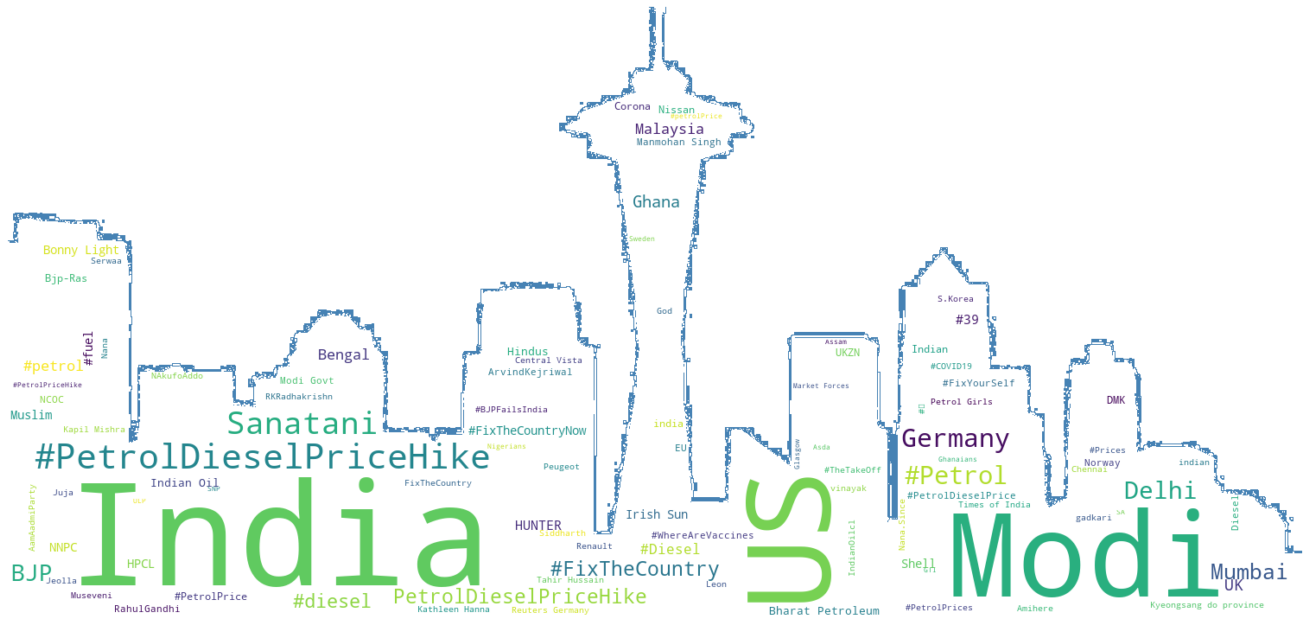

In [22]:
#@title Build Word Cloud For Top TAGs
Metric = 'Most Popular' #@param ["Most Popular", "Most Liked", "Most Replied", "Most Retweeted"]
#@markdown
Filter_TAG = False #@param {type:"boolean"}
##@markdown
TAG = 'Hashtag' #@param ["Hashtag", "Person", "Location", "Organization"]
Mask = 'Seattle' #@param ["Rectangle", "Seattle", "Balloon", "Horse"]

# get correct Metric value
if Metric == 'Most Popular':
   Metric = 'Frequency'
elif Metric == 'Most Liked':
   Metric = 'Total_Likes'
elif Metric == 'Most Replied':
   Metric = 'Total_Replies'
elif Metric == 'Most Retweeted':
   Metric = 'Total_Retweets'    

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

countDict = {}

for index, row in filtered_group.iterrows():
  if row[Metric] == 0:
    row[Metric] = 1
  countDict.update( {row['tag'] : row[Metric]} )
  
if Mask == 'Seattle':
  Mask = np.array(Image.open("seattle.jpg"))
elif Mask == 'Rectangle':
  Mask = np.array(Image.new('RGB', (800,600), (0, 0, 0)))
elif Mask == 'Horse':
  Mask = np.array(Image.open("horse.png"))
elif Mask == 'Balloon':
  Mask = np.array(Image.open("balloon.jpg"))

clear_output()

# Generate Word Cloud
wordcloud = WordCloud(
    max_words=100,
#     max_font_size=50,
    height=300,
    width=800,
    background_color = 'white',
    mask=Mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords = STOPWORDS).generate_from_frequencies(countDict)
fig = plt.figure(
    figsize = (18, 18),
    )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()